# 主成分分析

相当于无监督评估器的一种，可以从无标签的数据中挖掘出有趣的信息。

PCA 是一种非常基础的降维算法，经常被用于：  
* 数据可视化
* 噪音过滤
* 特征抽取
* 特征工程

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 主成分分析简介

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593763,
 1.0195904306706842)

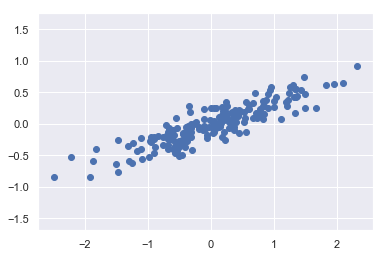

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:,0], X[:,1])
plt.axis('equal')

第一维特征和第二维具有明显的相关性，注意这里和前面不同，y不是最终要求的变量，x y 都是自变量   
主成分分析的思路是找到一个正交坐标系，使得所有样本点在坐标轴上的投影具有最大可分性，基本做法是对协方差矩阵做特征值分解，依据降维的需要逐层选择特征值和相应的特征向量作为坐标轴。   
如果PCA 成功，说明在去掉一些比较难分的信息以后，样本能够用于分类或回归的信息占比更大了，更容易凸显，这些信息刚好在整个数据保证样本最大可分时的前几个特征向量中，如果 PCA 效果不好，说明在降维的过程中，损失了一部分比较重要的信息  

### 仿射变换

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
# 成分，就是特征值向量
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
# 可解释差异 类似特征值
print(pca.explained_variance_)

[0.7625315 0.0184779]


In [6]:
def draw_vector(v0, v1, ax = None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                     linewidth = 2,
                     shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593763,
 1.0195904306706842)

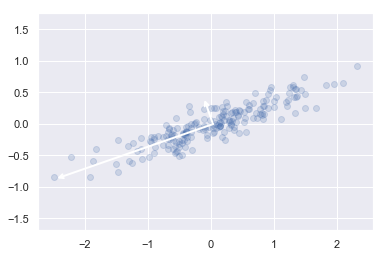

In [7]:
# 画出数据

plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')

长的就是主轴，相应的主成分   
这种变换称为仿射变换，包含平移，旋转和均匀缩放 （线性变化）  
所谓的降维，就是把最不重要的轴一个个舍去

### 降维

In [8]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape: ", X.shape)
print("transformed shape: ", X_pca.shape)

original shape:  (200, 2)
transformed shape:  (200, 1)


(-2.77152878069022, 2.661757596590677, -0.9964674432667127, 1.0219081775900811)

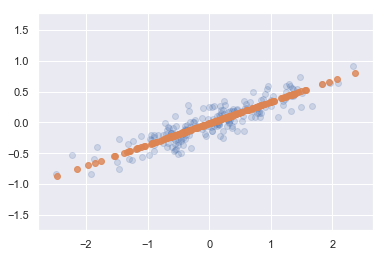

In [9]:
X_new = pca.inverse_transform(X_pca) # 逆变换，把一维的数据，转换到原来二维
plt.scatter(X[:, 0], X[:, 1], alpha = 0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha = 0.8)
plt.axis('equal')

### 可视化手写数字

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [11]:
pca = PCA(2)
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


画出每个点的前两个主成分，更好的了解数据

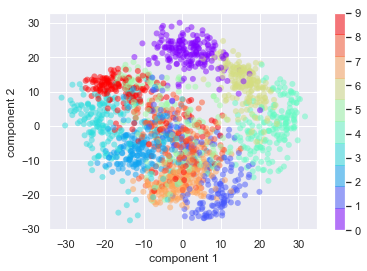

In [12]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

以上二维，是64维数据经过坐标仿射变换后，最能够将所有数据分散的前两轴，可以看到相关的表现

### 选择成分的数量（确定 n_component)

可以通过累计方差贡献率来判定

Text(0, 0.5, 'cumulative explained variance')

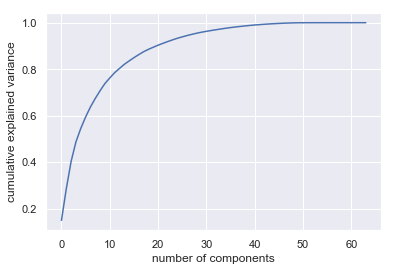

In [13]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

前 n 维中包含了 64 维中多少方差   
由上可以看出，二维的投影会损失很多方差，但是前 10 维就可以包含几乎75%的方差，如果希望描述接近100% 的方差，那么就需要大约 50 个成分

## 用PCA 做噪音过滤

任何成分的方差都应该远大于噪音的方差

首先画几个无噪音的输入数据

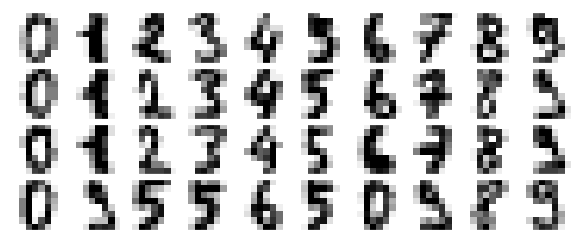

In [14]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8,8),
                 cmap='binary', interpolation='nearest',
                 clim=(0, 16))
plot_digits(digits.data)

加噪音

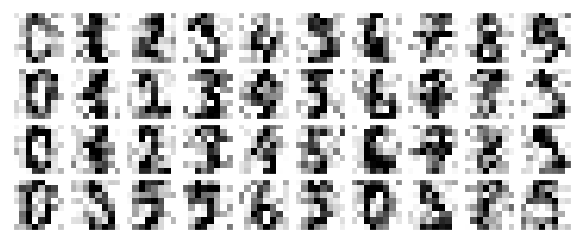

In [15]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

用噪音数据训练一个PCA，要求投影后保存 50% 的方差

In [16]:
# PCA 是可以提前不限定component, 也可以只限定需要解释的方差的量

pca = PCA(0.50).fit(noisy)
pca.n_components_

12

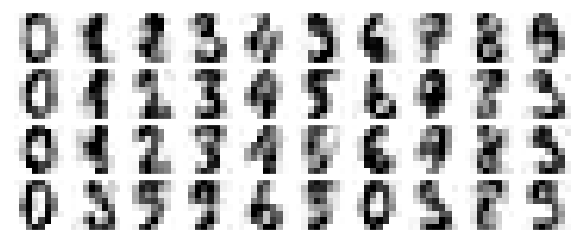

In [17]:
# 除噪以后的效果
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## 案例：特征脸

In [19]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [23]:
# 和传统PCA相比，他包含了一个随机的方法来估计前N个主成分，不然矩阵太大，求特征值可能有点慢
# RandomizedPCA 被pass了，用PCA的方法
from sklearn.decomposition import PCA
pca = PCA(n_components=150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

用前 n 个主成分（特征脸）来画图像，正如其名一样吓人

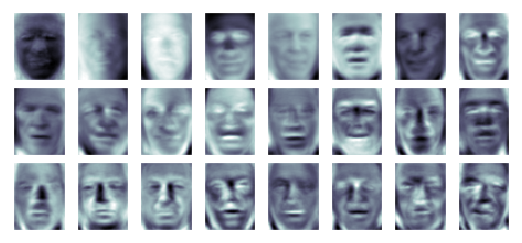

In [24]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap = 'bone')

Text(0, 0.5, 'cumulative explained variance')

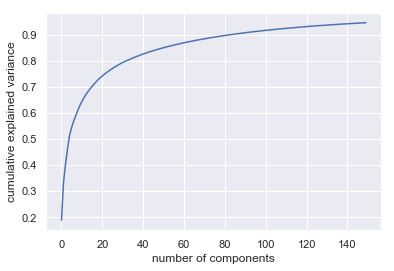

In [25]:
# 保留方差的情况
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

我们发现150个维度，其实已经包含了90%的方差，说明用这 150 维数据，应该就可以恢复数据的发部分必要特征，可以比较输入图像和利用这150个成分重构的图像。

In [26]:
pca = PCA(n_components=150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

Text(0, 0.5, '150-dim\nreconstruction')

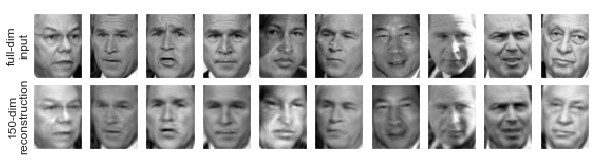

In [28]:
# 画出结果

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')

## 总结

**PCA 用途广泛，可解释性强**

* 可视化点间的关系
* 理解数据中的主要方差
* 理解固有的维度

PCA 不是一个对每个高维数据集都有效的方法，但是他提供了一条直接且有效的路径

**劣势：**
* 经常受到异常点影响，因此会有一些变体比如 RandomizedPCA 和 SparsePCA